In [36]:
import numpy as np
import sunpy 
import sunpy.map
from sunpy.coordinates import (propagate_with_solar_surface, 
                               Helioprojective, 
                               get_horizons_coord)
import eispac
from glob import glob
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import astropy.constants as const
from sunraster.instr.spice import read_spice_l2_fits
import os
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from sun_blinker import SunBlinker
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord,
                     CircleSkyRegion)
import h5py
import sunkit_image
import sunkit_image.coalignment as coalignment

In [2]:
eui_files = sorted(glob("../../../../src/EUI/HRI/euv174/20221020/coalign_step_boxcar/*.fits"))
hri_map_high = sunpy.map.Map(eui_files[181])
hri_map_low = sunpy.map.Map(eui_files[181])
hri_map_high.meta['rsun_ref'] = 696000000 + 2.8e6
hri_map_low.meta['rsun_ref'] = 696000000

In [3]:
Txshift_hri, Tyshift_hri = (9.41462 - 20.8515)*u.arcsec, (7.05089-8.29747)*u.arcsec

In [4]:
hri_map_high = hri_map_high.shift_reference_coord(Txshift_hri, Tyshift_hri)
hri_map_low = hri_map_low.shift_reference_coord(Txshift_hri, Tyshift_hri)

In [5]:
eis_195_velmap_derot = sunpy.map.Map('../../../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_velmap_shift.fits')
eis_195_velmap_derot.meta['rsun_ref'] = 696000000 + 2.8e6
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_195_velmap_derot_repro_hrifov = eis_195_velmap_derot.reproject_to(hri_map_high.wcs)

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


In [6]:
spice_coalign_filename = '../../../../src/SPICE/20221020/solo_L2_spice-n-ras_20221020T231536_V06_150995364-000_coalign.fits'
spice_coalign_cube = read_spice_l2_fits(spice_coalign_filename)
spice_coalign_cube.keys()

Set MJD-OBS to 59872.969168 from DATE-OBS.
Set MJD-BEG to 59872.969168 from DATE-BEG.
Set MJD-AVG to 59873.047270 from DATE-AVG.
Set MJD-END to 59873.125369 from DATE-END'. [astropy.wcs.wcs]


dict_keys(['O III 703 / Mg IX 706 (Merged)', 'S IV 750 - Peak', 'N IV 765 - Peak', 'Ne VIII 770 - Peak', 'S V 786 / O IV 787 (Merged)', 'N III 991 (Merged)'])

In [7]:
with fits.open(spice_coalign_filename) as hdul:
    spice_solarx_shift = hdul[-2].data.copy()
    spice_solary_shift = hdul[-1].data.copy()

In [8]:
spice_time = spice_coalign_cube['Ne VIII 770 - Peak'].time[0]

In [9]:
spice_window_test = spice_coalign_cube['Ne VIII 770 - Peak']

In [10]:
with fits.open(spice_coalign_filename) as hdul:
    hdul.info()
    spice_coalign_header = hdul[3].header.copy()

Filename: ../../../../src/SPICE/20221020/solo_L2_spice-n-ras_20221020T231536_V06_150995364-000_coalign.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  O III 703 / Mg IX 706 (Merged)    1 PrimaryHDU     411   (224, 832, 80, 1)   float32   
  1  S IV 750 - Peak    1 ImageHDU       406   (224, 832, 50, 1)   float32   
  2  N IV 765 - Peak    1 ImageHDU       406   (224, 832, 50, 1)   float32   
  3  Ne VIII 770 - Peak    1 ImageHDU       406   (224, 832, 50, 1)   float32   
  4  S V 786 / O IV 787 (Merged)    1 ImageHDU       412   (224, 832, 56, 1)   float32   
  5  N III 991 (Merged)    1 ImageHDU       412   (224, 832, 56, 1)   float32   
  6  VARIABLE_KEYWORDS    1 BinTableHDU    385   1R x 27C   [224D, 224I, 224I, 224I, 224I, 224I, 224E, 224E, 224E, 224E, 7I, 7I, 7I, 7I, 7J, 7J, 7J, 7J, 5152A, 224D, 224D, 80D, 50D, 50D, 50D, 56D, 56D]   
  7  WCSDVARR      1 ImageHDU        37   (224,)   float64   
  8  WCSDVARR      2 ImageHDU        37   (224,)   float64   


In [11]:
spice_coalign_header['CRVAL1'] = spice_coalign_header['CRVAL1'] - 14.2
spice_coalign_header['CRVAL2'] = spice_coalign_header['CRVAL2'] - 4.5

In [12]:
spice_coalign_wcs = WCS(spice_coalign_header).dropaxis(2)[:,120:700,:]

In [13]:
spice_coalign_wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 'UTC' 
CRVAL : -0.1369921977936497 0.16339940119161195 6747.875 
CRPIX : 112.5 296.5 1.0 
PC1_1 PC1_2 PC1_3  : 0.993437010613 -0.030482966841456 0.0 
PC2_1 PC2_2 PC2_3  : 0.42918742170158 0.993437010613 0.0 
PC3_1 PC3_2 PC3_3  : -60.25 0.0 1.0 
CDELT : 0.0011444444444444445 0.00030500000000000004 1.0 
NAXIS : 224  580  1

In [14]:
saffron_dir = '../../../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221020T231536_V06_150995364-000/con-06'

In [15]:
def interpolate_spice_map_to_target_wcs(spice_map, spice_coalign_wcs, spice_time,
                                        hri_map,
                                        spice_solarx_shift=spice_solarx_shift, 
                                        spice_solary_shift=spice_solary_shift):
    spice_nx = spice_nt = spice_map.data.shape[1]
    spice_map = spice_map.submap([0, 120]*u.pix, top_right=[spice_nx, 699]*u.pix)
    spice_ny = spice_map.data.shape[0]
    spice_pix_t, spice_pix_y, spice_pix_x = np.indices((1,*spice_map.data.shape))
    spice_world_coords = spice_coalign_wcs.pixel_to_world(spice_pix_x, spice_pix_y, spice_pix_t)[0][0,:,:]

    solar_orbiter_loc = np.flip(get_horizons_coord('solar orbiter',
                                                {'start':spice_time[-1],
                                                'stop':spice_time[0],
                                                'step':f'{spice_nt}'}))
    
    spice_pix_y_in_target_wcs = np.zeros((spice_ny, spice_nx))
    spice_pix_x_in_target_wcs = np.zeros((spice_ny, spice_nx))

    target_wcs = hri_map.wcs

    for ii in range(spice_nt):
        spice_world_coord_t = SkyCoord(spice_world_coords[:,ii].Tx.to(u.arcsec) + spice_solarx_shift[ii]*u.arcsec, 
                                  spice_world_coords[:,ii].Ty.to(u.arcsec) + spice_solary_shift[ii]*u.arcsec,
                                  frame='helioprojective',obstime=spice_time[ii], 
                                  observer=solar_orbiter_loc[ii], 
                                  rsun=hri_map.meta['rsun_ref']*u.m,)
        
        with propagate_with_solar_surface(rotation_model='rigid'):
            spice_pix_x_in_target_wcs[:,ii], spice_pix_y_in_target_wcs[:,ii] = target_wcs.world_to_pixel(spice_world_coord_t)

    hri_map_pix_y, hri_map_pix_x = np.indices(hri_map.data.shape)

    spice_map_interpolator = LinearNDInterpolator((spice_pix_x_in_target_wcs.flatten(), spice_pix_y_in_target_wcs.flatten()), spice_map.data.flatten())

    spice_map_interpolated = spice_map_interpolator(hri_map_pix_x, hri_map_pix_y)

    spice_map_interpolated = sunpy.map.Map(spice_map_interpolated, target_wcs)
    spice_map_interpolated.meta['rsun_ref'] = hri_map.meta['rsun_ref']

    return spice_map_interpolated

In [16]:
def get_saffron_map(saffron_dir, saffron_filename, spice_coalign_wcs, spice_time, hri_map, velmap=False):
    saffron_files = glob(os.path.join(saffron_dir, saffron_filename))

    saffron_intmaps = []
    if velmap:
        saffron_velmaps = []

    for saffron_file in saffron_files:
        saffron_map = sunpy.map.Map(saffron_file)
        saffron_intmap = saffron_map[0]
        saffron_widmap = saffron_map[2]
        saffron_intmap = sunpy.map.Map(saffron_intmap.data*saffron_widmap.data*np.sqrt(np.pi), saffron_intmap.meta)
        saffron_intmap = interpolate_spice_map_to_target_wcs(saffron_intmap, spice_coalign_wcs, spice_time, hri_map)

        saffron_intmap.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(saffron_intmap.data, 0.5),
                                                                vmax=np.nanpercentile(saffron_intmap.data, 99.5),
                                                                stretch=AsinhStretch())
        saffron_intmaps.append(saffron_intmap)


        if velmap:
            saffron_velmap = saffron_map[1]

            saffron_velmap_data = saffron_velmap.data.copy()
            saffron_velmap_data = (saffron_velmap_data/np.nanmedian(saffron_velmap_data) - 1)*const.c.to_value(u.km/u.s)
            saffron_velmap_median = np.nanmedian(saffron_velmap_data[120:699,:], axis=0)
            saffron_velmap_median_fit_param = np.polyfit(np.arange(saffron_velmap_median.shape[0]), saffron_velmap_median, 1)
            saffron_velmap_data = saffron_velmap_data - np.polyval(saffron_velmap_median_fit_param, np.arange(saffron_velmap_median.shape[0]))[np.newaxis,:]
            saffron_velmap = sunpy.map.Map(saffron_velmap_data, saffron_map[1].meta)

            saffron_velmap = interpolate_spice_map_to_target_wcs(saffron_velmap, spice_coalign_wcs, spice_time, hri_map)
            saffron_velmap.plot_settings['norm'] = ImageNormalize(vmin=-40, vmax=40)
            saffron_velmaps.append(saffron_velmap)

    if velmap:
        if len(saffron_files) == 1:
            return saffron_intmaps[0], saffron_velmaps[0]
        else:
            return saffron_intmaps, saffron_velmaps
    else:
        if len(saffron_files) == 1:
            return saffron_intmaps[0]
        else:
            return saffron_intmaps

In [17]:
saffron_NeVIII_intmap, saffron_NeVIII_velmap = get_saffron_map(saffron_dir, '*770.42-ne_8*.fits',
                                                                spice_coalign_wcs, spice_time, hri_map_high, velmap=True)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


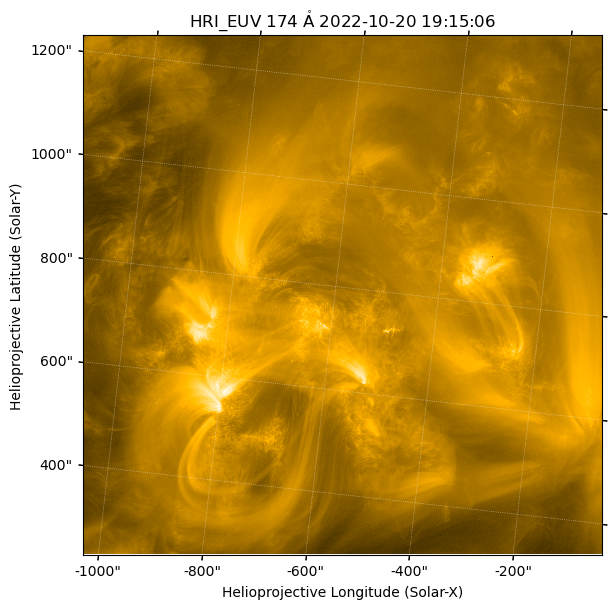

In [18]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map_high.wcs)
hri_map_high.plot(axes=ax)

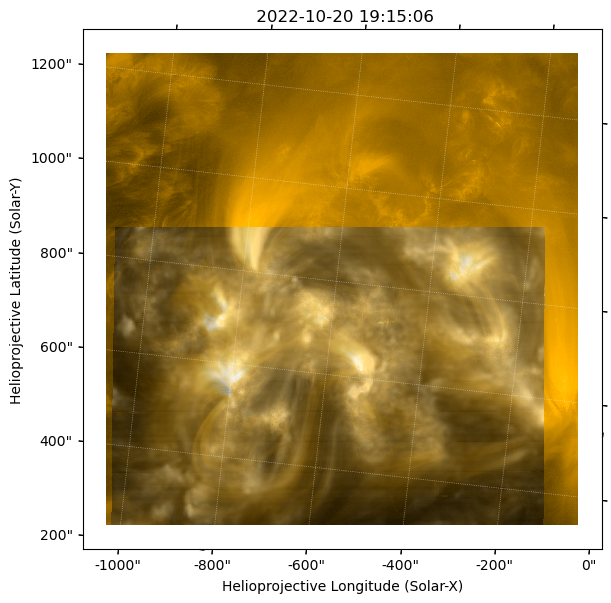

In [19]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map_high.wcs)
hri_map_high.plot(axes=ax)
saffron_NeVIII_intmap.plot(axes=ax, alpha=0.5,autoalign=True)

In [20]:
SunBlinker(hri_map_high, saffron_NeVIII_intmap, reproject=True)

In [21]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift

In [22]:
Txshift_spice_hri_high_additional, Tyshift_spice_hri_high_additional = coalign_shift(hri_map_high, 
                                                                                     saffron_NeVIII_intmap.submap([200,20]*u.pix, 
                                                                                                                  top_right=[1500, 1200]*u.pix))
Txshift_spice_hri_high_additional, Tyshift_spice_hri_high_additional

(<Angle -12.93317226 arcsec>, <Angle -5.34152188 arcsec>)

In [23]:
saffron_NeVIII_intmap = saffron_NeVIII_intmap.shift_reference_coord(Txshift_spice_hri_high_additional, Tyshift_spice_hri_high_additional)
saffron_NeVIII_intmap = saffron_NeVIII_intmap.reproject_to(hri_map_high.wcs)
saffron_NeVIII_velmap = saffron_NeVIII_velmap.shift_reference_coord(Txshift_spice_hri_high_additional, Tyshift_spice_hri_high_additional)
saffron_NeVIII_velmap = saffron_NeVIII_velmap.reproject_to(hri_map_high.wcs)

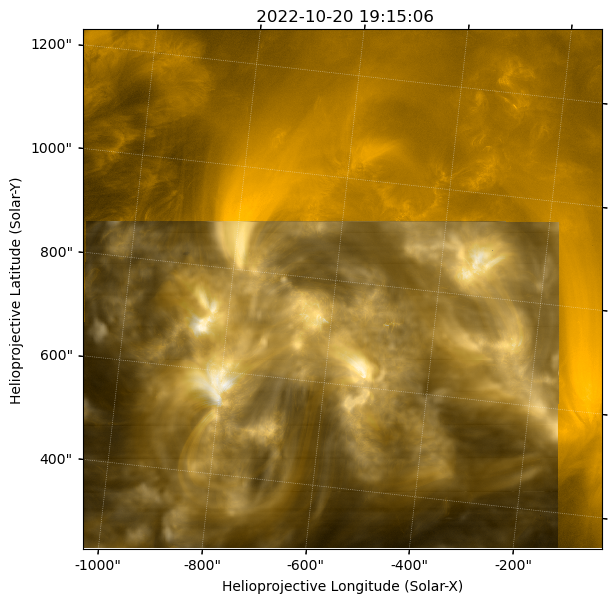

In [24]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map_high.wcs)
hri_map_high.plot(axes=ax)
saffron_NeVIII_intmap.plot(axes=ax, alpha=0.5)

In [25]:
SunBlinker(hri_map_high, saffron_NeVIII_intmap, reproject=True)

In [26]:
saffron_NeVIII_intmap.save('../../../../src/coalign_map/20221020/spice_NeVIII_intmap_derot_repro_hrifov.fits', overwrite=True)
saffron_NeVIII_velmap.save('../../../../src/coalign_map/20221020/spice_NeVIII_velmap_derot_repro_hrifov.fits', overwrite=True)

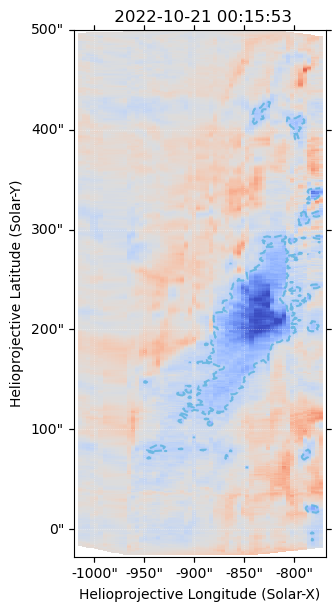

In [27]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=eis_195_velmap_derot.wcs)
eis_195_velmap_derot.plot(aspect=eis_195_velmap_derot.scale.axis2/eis_195_velmap_derot.scale.axis1,
                           norm=ImageNormalize(vmin=-20, vmax=20), 
                          cmap='coolwarm')
eis_195_velmap_derot.draw_contours(levels=[-5],colors=["#58B2DC"],alpha=0.8,
                                                                   axes=ax)

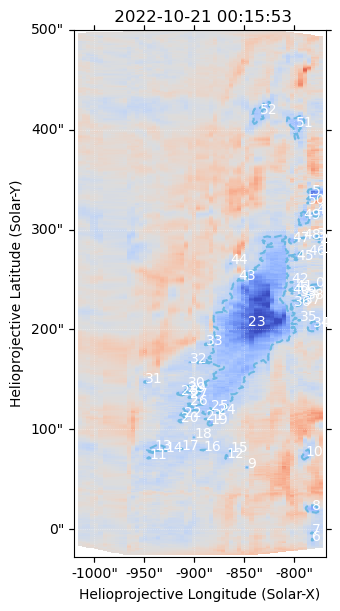

In [28]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=eis_195_velmap_derot.wcs)
eis_195_velmap_derot.plot(aspect=eis_195_velmap_derot.scale.axis2/eis_195_velmap_derot.scale.axis1,
                           norm=ImageNormalize(vmin=-20, vmax=20), 
                          cmap='coolwarm')
cs = eis_195_velmap_derot.draw_contours(levels=[-5],colors=["#58B2DC"],alpha=0.8,
                                                                   axes=ax)

for ii, seg in enumerate(cs.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

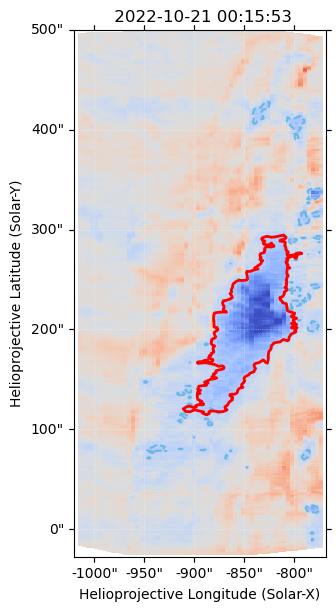

In [29]:
cs_selected_index = [23]

fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=eis_195_velmap_derot.wcs)
eis_195_velmap_derot.plot(aspect=eis_195_velmap_derot.scale.axis2/eis_195_velmap_derot.scale.axis1,
                           norm=ImageNormalize(vmin=-20, vmax=20), 
                          cmap='coolwarm')
cs = eis_195_velmap_derot.draw_contours(levels=[-5],colors=["#58B2DC"],alpha=0.8,
                                                                   axes=ax)

for ii in cs_selected_index:
    ax.plot(*cs.allsegs[0][ii].T, color='red', lw=2)

In [30]:
cs_skycoords = [eis_195_velmap_derot.pixel_to_world(np.concatenate([cs.allsegs[0][cs_selected_index_][:,0] \
                                                                for cs_selected_index_ in cs_selected_index])*u.pix,
                                                                np.concatenate([cs.allsegs[0][cs_selected_index_][:,1] \
                                                                for cs_selected_index_ in cs_selected_index])*u.pix) \
                ]
cs_regions = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords]

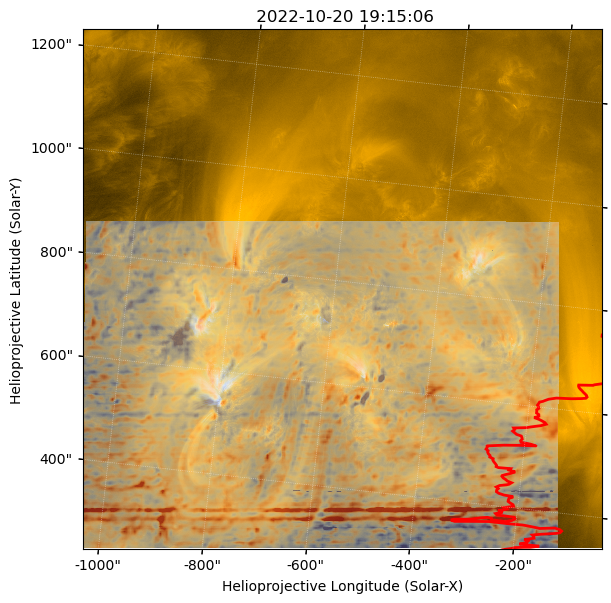

In [31]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map_high.wcs)
hri_map_high.plot(axes=ax)
saffron_NeVIII_velmap.plot(axes=ax, alpha=0.5, cmap='coolwarm')

with propagate_with_solar_surface(rotation_model='rigid'):
    cs_regions[0].to_pixel(hri_map_high.wcs).plot(ax=ax, edgecolor='red', lw=2)

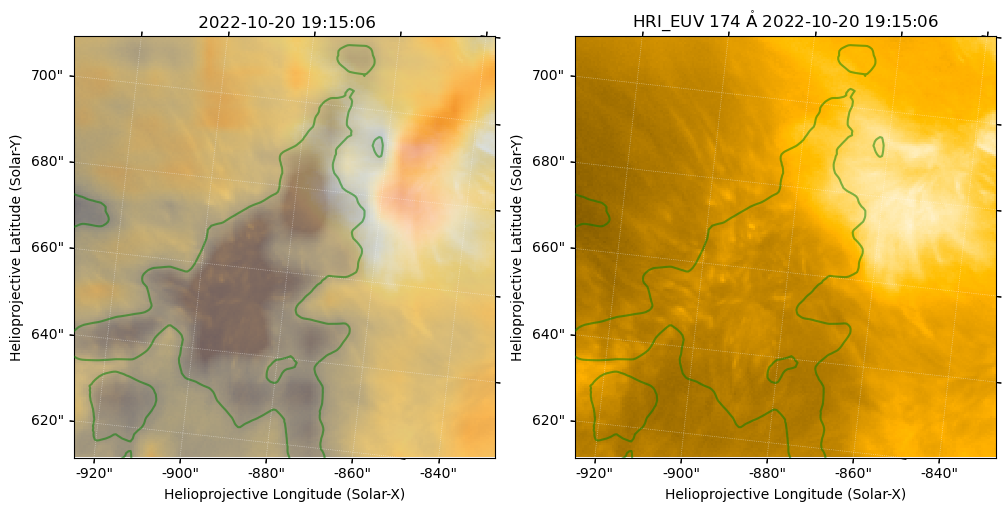

In [32]:
fig = plt.figure(figsize=(10,5),layout='constrained')
ax1 = fig.add_subplot(121,projection=hri_map_high.wcs)
hri_map_high.plot(axes=ax1)
saffron_NeVIII_velmap.plot(axes=ax1, alpha=0.5, cmap='coolwarm')

ax2 = fig.add_subplot(122,projection=hri_map_high.wcs)
hri_map_high.plot(axes=ax2)

for ax_ in (ax1,ax2):
    with propagate_with_solar_surface(rotation_model='rigid'):
        saffron_NeVIII_velmap.draw_contours(levels=[-20],colors=["green"],alpha=0.5,
                                                                    axes=ax_,linestyles='solid')
    ax_.set_xlim(300, 500)
    ax_.set_ylim(750,950)

In [33]:
def get_intensity_from_cs_regions(intensity_map, cs_regions):
    intensity = []
    with propagate_with_solar_surface(rotation_model='rigid'):
        masks = [np.where(cs_region.contains(sunpy.map.all_coordinates_from_map(intensity_map), 
                                                    intensity_map.wcs)) for cs_region in cs_regions]
        intensity = [intensity_map.data[mask_] for mask_ in masks]
    return intensity

In [34]:
spice_NeVIII_vel_eis_upflow_region = get_intensity_from_cs_regions(saffron_NeVIII_velmap, cs_regions)

In [35]:
spice_NeVIII_int_eis_upflow_region = get_intensity_from_cs_regions(saffron_NeVIII_intmap, cs_regions)

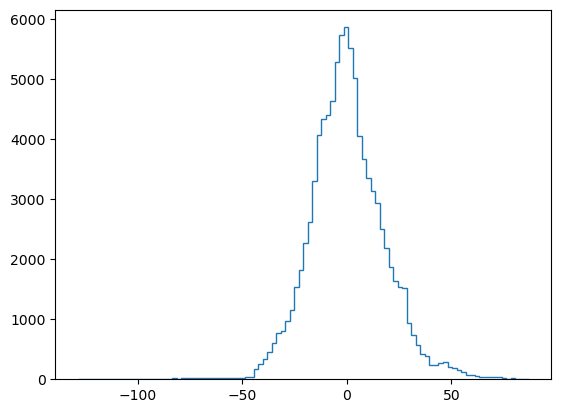

In [36]:
_ = plt.hist(spice_NeVIII_vel_eis_upflow_region[0], bins=100, histtype='step')

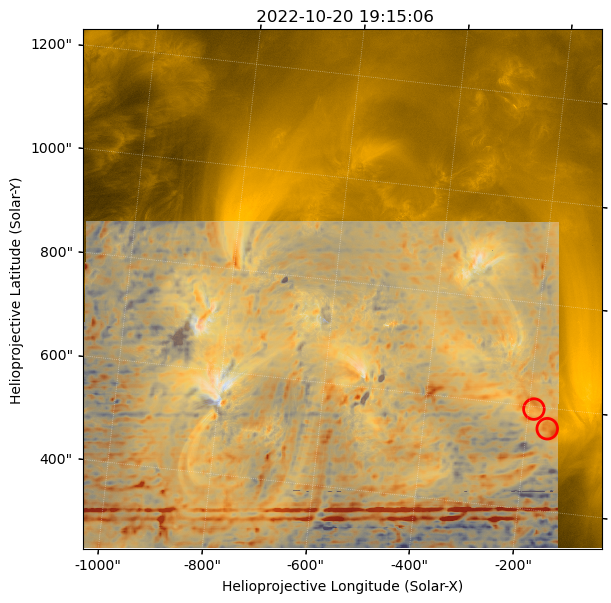

In [53]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map_high.wcs)
hri_map_high.plot(axes=ax)
saffron_NeVIII_velmap.plot(axes=ax, alpha=0.5, cmap='coolwarm')

loop_foot_point_region_1 = CircleSkyRegion(center=SkyCoord(-160*u.arcsec,
                                                           560*u.arcsec, frame=hri_map_high.coordinate_frame),
                                           radius=20*u.arcsec)
loop_foot_point_region_2 = CircleSkyRegion(center=SkyCoord(-190*u.arcsec,
                                                           595*u.arcsec, frame=hri_map_high.coordinate_frame),
                                           radius=20*u.arcsec)

loop_foot_point_region_1.to_pixel(hri_map_high.wcs).plot(ax=ax, edgecolor='red', lw=2)
loop_foot_point_region_2.to_pixel(hri_map_high.wcs).plot(ax=ax, edgecolor='red', lw=2)

In [49]:
spice_NeVIII_vel_loop_footpoint = get_intensity_from_cs_regions(saffron_NeVIII_velmap, 
                                                                [loop_foot_point_region_1 | loop_foot_point_region_2])

In [50]:
spice_NeVIII_int_loop_footpoint = get_intensity_from_cs_regions(saffron_NeVIII_intmap,
                                                                [loop_foot_point_region_1 | loop_foot_point_region_2])

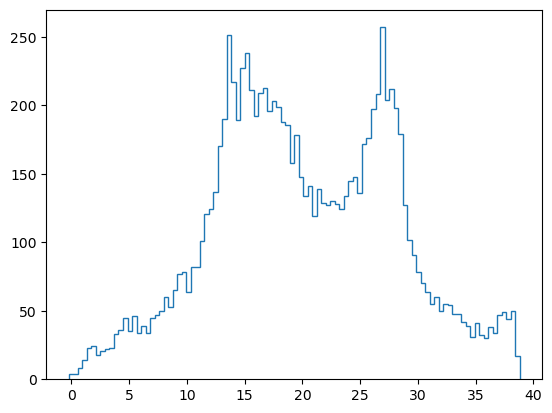

In [52]:
_ = plt.hist(spice_NeVIII_vel_loop_footpoint[0], bins=100, histtype='step')

In [54]:
saffron_OIII_intmaps = get_saffron_map(saffron_dir, '*o_3*.fits',
            spice_coalign_wcs, spice_time, hri_map_low, velmap=False)
for saffron_OIII_intmap_ in saffron_OIII_intmaps:
    saffron_OIII_intmap_ = saffron_OIII_intmap_.shift_reference_coord(Txshift_spice_hri_high_additional, Tyshift_spice_hri_high_additional)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


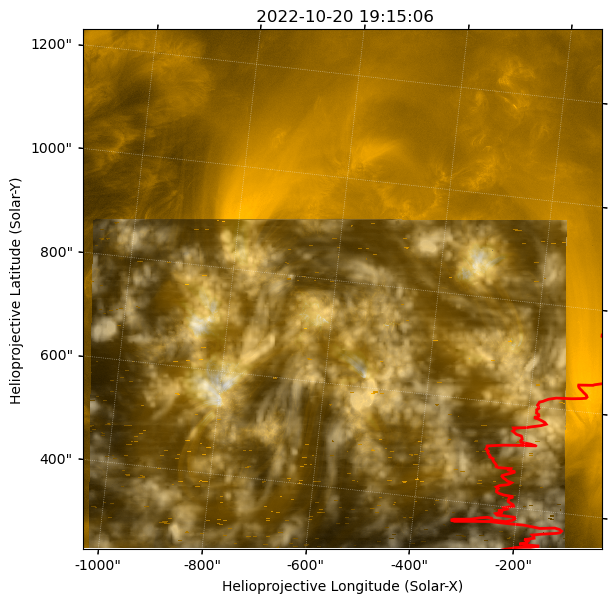

In [55]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map_low.wcs)
hri_map_low.plot(axes=ax)
saffron_OIII_intmaps[0].plot(axes=ax, alpha=0.5)

with propagate_with_solar_surface(rotation_model='rigid'):
    cs_regions[0].to_pixel(hri_map_low.wcs).plot(ax=ax, edgecolor='red', lw=2)

In [56]:
spice_OIII_int_eis_upflow_region = get_intensity_from_cs_regions(saffron_OIII_intmaps[0], cs_regions)

In [66]:
spice_OIII_int_loop_footpoint = get_intensity_from_cs_regions(saffron_OIII_intmaps[0],
                                                                [loop_foot_point_region_1 | loop_foot_point_region_2])

In [57]:
saffron_MgIX_intmap = get_saffron_map(saffron_dir, '*706.02-mg_9*.fits',
            spice_coalign_wcs, spice_time, hri_map_high, velmap=False)
saffron_MgIX_intmap = saffron_MgIX_intmap.shift_reference_coord(Txshift_spice_hri_high_additional, Tyshift_spice_hri_high_additional)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


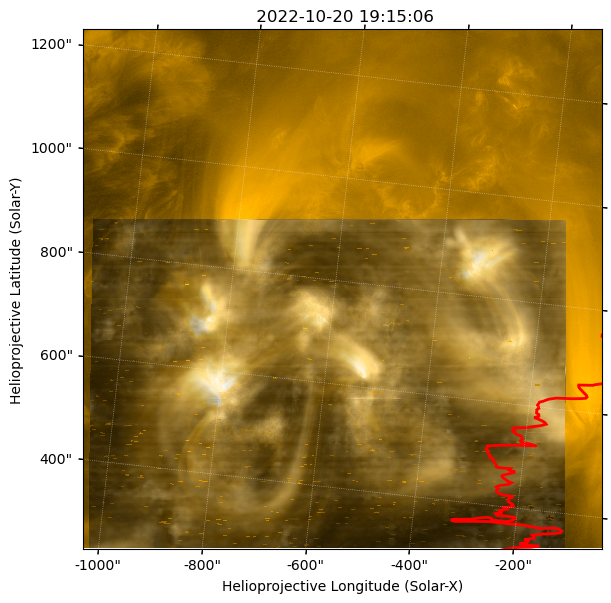

In [58]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map_high.wcs)
hri_map_high.plot(axes=ax)
saffron_MgIX_intmap.plot(axes=ax, alpha=0.5)

with propagate_with_solar_surface(rotation_model='rigid'):
    cs_regions[0].to_pixel(hri_map_high.wcs).plot(ax=ax, edgecolor='red', lw=2)

In [59]:
SunBlinker(hri_map_high, saffron_MgIX_intmap)

In [60]:
spice_MgIX_int_eis_upflow_region = get_intensity_from_cs_regions(saffron_MgIX_intmap, cs_regions)

In [67]:
spice_MgIX_loop_footpoint = get_intensity_from_cs_regions(saffron_MgIX_intmap,
                                                                [loop_foot_point_region_1 | loop_foot_point_region_2])

In [61]:
saffron_NIV_intmap = get_saffron_map(saffron_dir, '*765.15-n_4*.fits',
            spice_coalign_wcs, spice_time, hri_map_low, velmap=False)
saffron_NIV_intmap = saffron_NIV_intmap.shift_reference_coord(Txshift_spice_hri_high_additional, Tyshift_spice_hri_high_additional)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


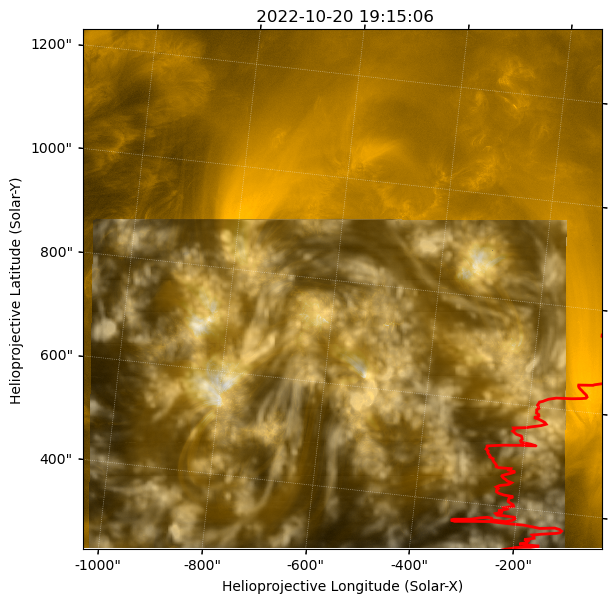

In [62]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map_low.wcs)
hri_map_low.plot(axes=ax)
saffron_NIV_intmap.plot(axes=ax, alpha=0.5)

with propagate_with_solar_surface(rotation_model='rigid'):
    cs_regions[0].to_pixel(hri_map_low.wcs).plot(ax=ax, edgecolor='red', lw=2)

In [63]:
spice_NIV_int_eis_upflow_region = get_intensity_from_cs_regions(saffron_NIV_intmap, cs_regions)

In [68]:
spice_NIV_int_loop_footpoint = get_intensity_from_cs_regions(saffron_NIV_intmap,
                                                                [loop_foot_point_region_1 | loop_foot_point_region_2])

In [64]:
hri_int_eis_upflow_region = get_intensity_from_cs_regions(hri_map_low, cs_regions)

In [69]:
hri_int_loop_footpoint = get_intensity_from_cs_regions(hri_map_low,
                                                                [loop_foot_point_region_1 | loop_foot_point_region_2])

In [65]:
with h5py.File('../../../../sav/SPICE/upflow_region/west_upflow_violin_spice.h5','w') as hdul:
    hdul.create_dataset('ne_8_770_vel',data=spice_NeVIII_vel_eis_upflow_region[0])
    hdul.create_dataset('ne_8_770_int',data=spice_NeVIII_int_eis_upflow_region[0])
    hdul.create_dataset('o_3_703_int',data=spice_OIII_int_eis_upflow_region[0])
    hdul.create_dataset('mg_9_706_int',data=spice_MgIX_int_eis_upflow_region[0])
    hdul.create_dataset('n_4_765_int',data=spice_NIV_int_eis_upflow_region[0])
    hdul.create_dataset('hri_int',data=hri_int_eis_upflow_region[0])

In [71]:
with h5py.File('../../../../sav/SPICE/upflow_region/west_loop_footpoint_violin_spice.h5','w') as hdul:
    hdul.create_dataset('ne_8_770_vel',data=spice_NeVIII_vel_loop_footpoint[0])
    hdul.create_dataset('ne_8_770_int',data=spice_NeVIII_int_loop_footpoint[0])
    hdul.create_dataset('o_3_703_int',data=spice_OIII_int_loop_footpoint[0])
    hdul.create_dataset('mg_9_706_int',data=spice_MgIX_loop_footpoint[0])
    hdul.create_dataset('n_4_765_int',data=spice_NIV_int_loop_footpoint[0])
    hdul.create_dataset('hri_int',data=hri_int_loop_footpoint[0])